# Checking geogrid

### 0.0 Import all the modules

In [1]:
import os
import csv
import numpy as np                  # For doing math
import matplotlib.pyplot as plt     # For plotting
import matplotlib.dates as mdates   # For formatting dates when plotting
import matplotlib.colors as colors  # For truncating colorbars
import matplotlib.style as style
import xarray as xr                 # For dealing with netCDF data
import pandas as pd                 # A quick way to deal with time stamps
import netCDF4 as nc                # Another way to deal with netCDF data
import glob
import metpy.calc as mpcalc
import datetime
import matplotlib.units as munits
import scipy.interpolate
import scipy.signal as sig
import scipy.stats as stats
import sys
import scipy.io as sio

from scipy.optimize import curve_fit
# from netCDF4 import Dataset
from matplotlib import colors as mcolors
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units
from scipy.signal import savgol_filter
from scipy.stats import binned_statistic
from matplotlib.gridspec import GridSpec
from numpy.random import seed
from numpy.random import rand
from datetime import datetime


print('Done importing modules now')

import warnings
warnings.filterwarnings('ignore')

# Make sure the environment is good ** especially important if running on another machines
import matplotlib
from netCDF4 import Dataset
from xarray import DataArray
from wrf import (getvar, interplevel, vertcross, 
                 vinterp, ALL_TIMES, extract_global_attrs)
import matplotlib.style as style
import cartopy.crs as ccrs          # For plotting maps
import cartopy.feature as cfeature  # For plotting maps


Done importing modules now


This notebook assumes that your data is located in WRF_DIRECTORY. If you used a different directory structure, you will need to modify it.

In [2]:
WRF_DIRECTORY = '/projects/jiko1138/'
DIR_1 = 'ATOC_NWP/Boulder'

### 1.0 Make the terrain map of the domain from the geo_em files

In [3]:
DIR_1_d01 = xr.open_dataset(WRF_DIRECTORY + DIR_1 + "/geo_em.d01.nc")
DIR_1_d02 = xr.open_dataset(WRF_DIRECTORY + DIR_1 + "/geo_em.d02.nc")
DIR_1_d03 = xr.open_dataset(WRF_DIRECTORY + DIR_1 + "/geo_em.d03.nc")

In [4]:
# Figure out the ref_lat and ref_lon we requested
# (Note this is mixing Datasets and xarray functions...)
ncfile = WRF_DIRECTORY+DIR_1+"/geo_em.d01.nc"
nc_fid = Dataset(ncfile, 'r')  # Dataset is the class behavior to open the file
                             # and create an instance of the ncCDF4 class

desired_lon = nc_fid.getncattr('CEN_LON')
desired_lat = nc_fid.getncattr('CEN_LAT')

print(desired_lon)
print(desired_lat)

# desired_lon = -91.7107986
# desired_lat = 41.8846886

-95.0
40.0


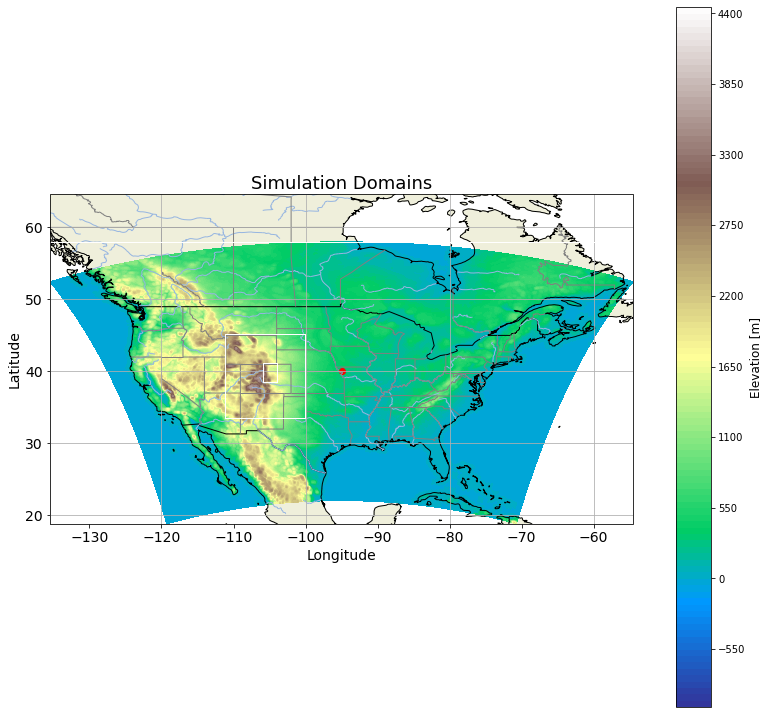

In [5]:
### Useful data and parameters for plotting

c_levels = np.arange(-1000, 4500, 50)

## Pull lat/lon from the dataset
lats1 = DIR_1_d01['XLAT_M'].isel(Time=0) 
longs1 = DIR_1_d01['XLONG_M'].isel(Time=0)
hgt1 = DIR_1_d01['HGT_M'].isel(Time=0)

lats2 = DIR_1_d02['XLAT_M'].isel(Time=0)
longs2 = DIR_1_d02['XLONG_M'].isel(Time=0)
hgt2 = DIR_1_d02['HGT_M'].isel(Time=0)

lats3 = DIR_1_d03['XLAT_M'].isel(Time=0)
longs3 = DIR_1_d03['XLONG_M'].isel(Time=0)
hgt3 = DIR_1_d03['HGT_M'].isel(Time=0)

## Extract min/max values if you chose to bound the size of the map
min_lat1 = lats1.values.min()
max_lat1 = lats1.values.max()
min_lon1 = longs1.values.min()
max_lon1 = longs1.values.max()
MAP_BOUNDS1 = [min_lon1, max_lon1, min_lat1, max_lat1]

min_lat2 = lats2.values.min()
max_lat2 = lats2.values.max()
min_lon2 = longs2.values.min()
max_lon2 = longs2.values.max()
MAP_BOUNDS2 = [min_lon2, max_lon2, min_lat2, max_lat2]

min_lat3 = lats3.values.min()
max_lat3 = lats3.values.max()
min_lon3 = longs3.values.min()
max_lon3 = longs3.values.max()
MAP_BOUNDS3 = [min_lon3, max_lon3, min_lat3, max_lat3]

# Create figure and axes objects
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())

# Bound and fill in nice lines

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

ax.set_extent([min_lon1,max_lon1,min_lat1,max_lat1])

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS)
ax.gridlines()
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(states_provinces, edgecolor='gray')
# ax.add_feature(cfeature.LAKES, edgecolor='k', zorder=1)
# ax.add_feature(cfeature.OCEAN, edgecolor='k', zorder=1)
# ax.coastlines('50m', linewidth=0.5)

# Draw bounding box for inner domain
ax.plot((min_lon1, min_lon1), (min_lat1, max_lat1), lw=1, color='w')
ax.plot((max_lon1, max_lon1), (min_lat1, max_lat1), lw=1, color='w')
ax.plot((min_lon1, max_lon1), (min_lat1, min_lat1), lw=1, color='w')
ax.plot((min_lon1, max_lon1), (max_lat1, max_lat1), lw=1, color='w')

ax.plot((min_lon2, min_lon2), (min_lat2, max_lat2), lw=1, color='w')
ax.plot((max_lon2, max_lon2), (min_lat2, max_lat2), lw=1, color='w')
ax.plot((min_lon2, max_lon2), (min_lat2, min_lat2), lw=1, color='w')
ax.plot((min_lon2, max_lon2), (max_lat2, max_lat2), lw=1, color='w')

ax.plot((min_lon3, min_lon3), (min_lat3, max_lat3), lw=1, color='w')
ax.plot((max_lon3, max_lon3), (min_lat3, max_lat3), lw=1, color='w')
ax.plot((min_lon3, max_lon3), (min_lat3, min_lat3), lw=1, color='w')
ax.plot((min_lon3, max_lon3), (max_lat3, max_lat3), lw=1, color='w')

im=ax.contourf(DIR_1_d01['XLONG_M'].values[0, :, :],
    DIR_1_d01['XLAT_M'].values[0, :, :],
    DIR_1_d01['HGT_M'].values[0, :, :], c_levels,
    cmap=plt.cm.terrain, projection=ccrs.LambertConformal())


# Add important info to the plot
ax.set_title("Simulation Domains", fontsize=18)
ax.xaxis.set_visible(True)    # Set xaxis visible because cartopy hides it by default
ax.yaxis.set_visible(True)
ax.tick_params(labelsize=14)
ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)

ax.scatter([desired_lon], [desired_lat], color='r') # Dot for location of BAO

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.1, 0.04, 0.81])      
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Elevation [m]", fontsize=12)


plt.show()

###### 

In [13]:
ds = xr.open_mfdataset("/projects/jiko1138/ATOC_NWP/Boulder/geo_em.d01.nc")

lats = ds['XLAT_M'].isel(Time=0)    # Note: we must index-select Time=0 because plots expect 2D data (lat-lon)
longs = ds['XLONG_M'].isel(Time=0)

km_lon = 100 #at 25.89 N, 100 km at 40 deg N, 85 km per degree of longitude
km_lat = 111 # 111 km per degree of latitude
 
# desired_lon = -94.222610
# desired_lat = 29.668834

desired_lon = -105.004
desired_lat = 40.0500

# desired_lon = -93.99438
# desired_lat = 29.633652

guess = 0.5 * np.size(longs[0,:]) + 1
print(np.round(guess))
south_north_index_2=163 # guess as half the domain dimension+1
west_east_index_2=145
this_lat_2 = ds['XLAT_M'].isel(Time=0,south_north=south_north_index_2,west_east=west_east_index_2)
this_lon_2 = ds['XLONG_M'].isel(Time=0,south_north=south_north_index_2,west_east=west_east_index_2)

dist_2 = np.sqrt(np.square(abs(km_lon*(longs[:,:] - desired_lon))) 
                    + np.square(abs(km_lat*(lats[:,:] - desired_lat))))
print("Closest point is distance: ",np.round(np.min(dist_2).values,3)," km")
print("This point is distance: ",np.round(np.sqrt(np.square(abs(km_lon*(this_lon_2.values - desired_lon))) 
                    + np.square(abs(km_lat*(this_lat_2.values - desired_lat)))),2), " km")

213.0
Closest point is distance:  3.22  km
This point is distance:  3.22  km


In [12]:
def destagger(var, stagger_dim):
    '''
    From wrf-python https://github.com/NCAR/wrf-python/blob/b40d1d6e2d4aea3dd2dda03aae18e268b1e9291e/src/wrf/destag.py 
    '''
    var_shape = var.shape
    num_dims = var.ndim
    stagger_dim_size = var_shape[stagger_dim]

    full_slice = slice(None)
    slice1 = slice(0, stagger_dim_size - 1, 1)
    slice2 = slice(1, stagger_dim_size, 1)

    dim_ranges_1 = [full_slice] * num_dims
    dim_ranges_2 = [full_slice] * num_dims

    dim_ranges_1[stagger_dim] = slice1
    dim_ranges_2[stagger_dim] = slice2

    result = .5*(var[tuple(dim_ranges_1)] + var[tuple(dim_ranges_2)])

    return result

Now read in all the files and the appropriate data from each of the files

In [12]:
# Get the list of all the wrfout files in the directory

# DIR_1_d01 = xr.open_dataset(WRF_DIRECTORY+DIR_1+"/wrfout_d01_2015-04-06_00:00:00")

DIR_TO_PLOT = DIR_1
DIR_TO_PLOT = DIR_2
# DIR_TO_PLOT = DIR_3


filenames = sorted([f for f in glob.glob(WRF_DIRECTORY+DIR_TO_PLOT+"/wrfout_d02_*")])
# print(filenames)

# loop through the files and read in the u, v, height, and time 
Times = []
xtime =[]
height =[]
u =[]
v =[]
pblh = []

for f in filenames :
    print('Reading ',f)
    ds = nc.Dataset(f)
    start = f.find('d02_') + 4
    test = f[start:] # 2015-04-06_00:00:00
    new_test = datetime.strptime(test, '%Y-%m-%d_%H:%M:%S')

#     print(test)
    Times.append(new_test)
#     height = ( PH + PHB ) / 9.81
#     height.append(ds['height'][:])

# Here we are using height above the ground
    height.append(( ds['PH'][:]+ds['PHB'][:])/9.81 - ds['HGT'][:])
    
    u.append(ds['U'][:])
    v.append(ds['V'][:])
#     Times.append(ds.variables['Times'][:])
    xtime.append(ds['XTIME'][:])
    pblh.append(ds['PBLH'][:])
    
height = np.squeeze(height)
u = np.squeeze(u)
v = np.squeeze(v)
Times = np.squeeze(Times)
xtime = np.squeeze(xtime)
pblh = np.squeeze(pblh)

print('Height:',np.shape(height))
# print('U:',np.shape(u))
# print('V:',np.shape(v))
print('Times:',np.shape(Times))
print('xtime:',np.shape(xtime))

# unstagger velocities after reading everything in

u_destag = destagger(u, 3)
v_destag = destagger(v, 2)
height_destag = destagger(height, 1)

# print('U:',np.shape(u_destag))
# print('V:',np.shape(v_destag))

u = u_destag # could probably have done this in one line with the destagger call
v = v_destag
height = height_destag

print('U:',np.shape(u))
print('V:',np.shape(v))
print('Height:',np.shape(height))

ws = (u**2 + v**2)**0.5

print('Wind Speed:',np.shape(ws))


NameError: name 'DIR_2' is not defined

In [ ]:

# A better way to find the location we want:
km_lon = 100 #at 25.89 N, 100 km at 40 deg N, 85 km per degree of longitude -- should really use a projection here
km_lat = 111 # 111 km per degree of latitude

dist = np.sqrt(np.square(abs(km_lon*(longs2[:,:] - desired_lon))) 
                    + np.square(abs(km_lat*(lats2[:,:] - desired_lat))))
#ind_max_s = np.unravel_index(np.argmin(dist, axis=None), dist.shape)
# Not working....
ind_max_s=[39,49]   # Just trust me on this for now...this is the location of the tower

#Now create a contour plot of time on the x-axis and height on the y-axis

fig, ax = plt.subplots(1,1,figsize=(12,8), sharex=True, sharey=True)
c_levels = np.arange(0, 20)
                       
time_axis = xtime

winds = ws[:,:,ind_max_s[0],ind_max_s[1]]
# print(np.min(winds),np.max(winds))
windst = np.transpose(winds)
# print(np.shape(windst))

im = ax.contourf(
#     time_axis/60,
    Times,
    height[0,:,ind_max_s[0],ind_max_s[1]],
    windst, c_levels,
    cmap=plt.cm.viridis)

plt.suptitle("Wind Speed at BAO tower from "+DIR_TO_PLOT, fontsize=24)

# ax.set_xlabel("Times (hour after "+ds.SIMULATION_START_DATE)
ax.set_xlabel("Times (MM-DD HH [UTC])")
ax.set_ylabel("Height [m]")
ax.set_ylim(0,1000)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
                                                                 
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Winds [m/s]")

end = DIR_TO_PLOT.find('/', 0)
# print(end)
# print(DIR_TO_PLOT[0:end])
DIR_TO_PLOT_WITHOUT_SLASH = DIR_TO_PLOT[0:end]

plt.savefig("wind_speed_contour_"+DIR_TO_PLOT_WITHOUT_SLASH+".png")
plt.savefig("wind_speed_contour_"+DIR_TO_PLOT_WITHOUT_SLASH+".pdf")

plt.show()

In [ ]:
test = '2015-04-06_00:00:00'
print(test)
print(datetime.strptime(test,'%Y-%m-%d_%H:%M:%S'))

In [ ]:
# Create a time series for a specific quantity, pblh

fig, ax = plt.subplots(1,1,figsize=(12,6), sharex=True, sharey=True)
c_levels = np.arange(0, 20)
                       
time_axis = xtime


im = ax.plot(
#     time_axis/60,
    Times,
    pblh[:,ind_max_s[0],ind_max_s[1]])

plt.suptitle("PBLH at BAO tower from "+DIR_TO_PLOT, fontsize=24)

# ax.set_xlabel("Times (hour after "+ds.SIMULATION_START_DATE)
ax.set_xlabel("Time (MM-DD HH [UTC])")
ax.set_ylabel("PBLH [m]")
ax.set_ylim(0,3000)

end = DIR_TO_PLOT.find('/', 0)
# print(end)
# print(DIR_TO_PLOT[0:end])
DIR_TO_PLOT_WITHOUT_SLASH = DIR_TO_PLOT[0:end]

plt.savefig("pblh_"+DIR_TO_PLOT_WITHOUT_SLASH+".png")
plt.savefig("pblh_"+DIR_TO_PLOT_WITHOUT_SLASH+".pdf")

plt.show()
